### Why is knowing the variance of WBO with respect to conformation important?  
1. WBO is a function of the electronic density which is a function of the conformation. But we want to use the WBO as a criterion for fragmenting molecules and we don't want to generate many conformations for this step because it's too expensive. 
2. It seems like the variance is higher for more conjugated bonds which we are interested in. However, if the distribution of those bond orders are around the cutoff value, how do we choose the cuttoff? While in general the higher variance bonds also have higher WBO (above the cutoff), I found that certain bonds are ambiguous. The variance is on the hihger side and the WBO is distributed around the cutoff value.  


Turns out, while the standard deviations are pretty low (0.08 is at the higher end), some of the more ambigous bonds
that have high bond order correlations with neighboring rings or other bonds, have a slightly higher variance (not as high as the aromatics in the rings). The most troubling thing is that the distribution is over where the WBO is. (1.05-1.15). So if we continue with a hard cutoff in that range, we might miss some of these because of the conformation.  
Examples of this:
(These are not obvious ones like amides which we'll just tag)  
Most of these are nitrogens next to aromatic rings. Ethers next to aromatic rings tend to have lower WBO but also higher variance 


* Abmaciclib bond (12, 13)  
* Afitinib (16, 20)  
* Bosutinib (13, 14), (7,13)   
* Brigatinib (11, 14), (20, 21), (25, 27)
* Ceritinib (18, 19), (23, 25) ?? (18,4), (5, 14) (these are lower BO but high variance)
* Desatinib (4, 6), (9, 14) ?? (6, 7) (low WBO but high variance)
* Erlotinib (20, 21), ?? (11, 12), (6, 5) (low WBO but high variance - ether next to aromatic ring)
* Gefitinib (19, 23) ?? (3, 2), (8, 9) (low WBO but high variance - ether next to aromatic rings)  
 - This is a good example for figure / illustration
* Ibrutinib (5, 3) technically an amide
* Idelalisib (23, 24)
* Imatinib (10, 11)
 - Decent example for the N attached to aromatic ring which
* Lapatinib (20, 24) ?? (24, 25) lower WBO but higher variance
* Neratinib (17, 18)
* Nilotininb is a mess - clean up the data
* Nintedanib (19, 20), 
* Osimertinib (13, 17), (17, 18), (22, 24), 
* Palbociclib (25, 28), (21, 6)
* Pazopanib (15, 13) ?? (8, 9), (5, 8), (28, 31) lower WBO but higher variance
* Regorafenib ?? (15, 18)
* Ribociclib (20, 11), (24, 27), ?? (20, 21) lower WBO but higher variance
* Sunitinib (13, 17) 
 - This is a good example for figure / illustration
* Tofacitinib (10, 12), (6, 21 ) - amide attached to a ring
* Vandetanib (18, 22) ?? (22, 23) lower WBO but higher variance, (9, 10) (15, 16) (ethers attached to aromatic rings)
* Vemurafenib ?? (8, 7), (7, 4) lower WBO but higher variance. 


I only looked at psi4 optimized WBO. I also want to look at:
* Psi4 Mayer unoptimized
* Psi4 Mayer optimized goemetry
* Psi4 Wiberg unoptimized
* OE Wiberg bond orders

_ToDo_: _Generate plot of Boltzman average WBO vs. std. There should be a positive correlation_

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from fragmenter import chemi
from openeye import oechem
import oenotebook as oenb
import json
import numpy as np
import glob
import cmiles
import os
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sbn
import pandas as pd
import matplotlib.image as mpimg

In [2]:
directories = [x[0] for x in os.walk('../conjugation/geometry_opt/')][1:]

In [3]:
output = {}
for kinase_inhibitor in directories:
    ki_key = kinase_inhibitor.split('/')[-1]
    output[ki_key] = []
    output_files = glob.glob('../conjugation/geometry_opt/{}/*.bo.json'.format(ki_key))
    for file in output_files:
        with open(file, 'r') as f:
            data = json.load(f)
        error = data['error']
        if error:
            print(error)
            continue
        data['bond_orders'] = chemi.bond_order_from_psi4_raw_output(data['raw_output'])
        data.pop('raw_output')
        output[ki_key].append(data)

RuntimeError('\nFatal Error: Iterations did not converge.\nError occurred in file: /scratch/psilocaluser/conda-builds/psi4_1514132855674/work/psi4/src/psi4/libpsi4util/process.cc on line: 112\nThe most recent 5 function calls were:\n\npsi::die_if_not_converged()\npsi::scf::HF::finalize_E()\npsi::scf::HF::compute_energy()\n',)


In [4]:
def collect_all_std(data, hydrogen=False, rings=False, only_rings=False, halogens=False, carbonyls=False, nitriles=False):

    bond_order_std = {}
    for ki in data: 
        if len(data[ki]) == 0:
            continue
        bond_order_std[ki] = {}
        conformations = len(data[ki])
        mol = cmiles.utils.load_molecule(data[ki][0]['tagged_smiles'])
        n_atoms = mol.NumAtoms()
        bond_order_wiberg = {}
        bond_order_mayer = {}
        for bond in mol.GetBonds():
            if only_rings and not rings:
                raise RuntimeError("If only rings is True, rings must be true")
            if only_rings:
                if not bond.IsInRing():
                    continue
            if not rings:
                if bond.IsInRing():
                    continue
            atom_1 = bond.GetBgn()
            atom_2 = bond.GetEnd()
            if not hydrogen:
                if atom_1.IsHydrogen() or atom_2.IsHydrogen():
                    continue
            if not halogens:
                if atom_1.IsHalogen() or atom_2.IsHalogen():
                    continue
            if not nitriles:
                if bond.GetOrder() == 3:
                    continue
            if not carbonyls:
                if bond.GetOrder() == 2 and (atom_1.IsOxygen() or atom_2.IsOxygen()):
                    continue
            map_1 = atom_1.GetMapIdx()
            map_2 = atom_2.GetMapIdx()
            bond_order_wiberg[(map_1, map_2)] = np.zeros(conformations)
            bond_order_mayer[(map_1, map_2)] = np.zeros(conformations)

        # Populate array
        for k, d in enumerate(data[ki]):
            wiberg = d['bond_orders']['Wiberg_psi4']
            mayer = d['bond_orders']['Mayer_psi4']
            for i, j in bond_order_wiberg:
                bond_order_wiberg[(i, j)][k] = wiberg[i-1][j-1]
                bond_order_mayer[(i, j)][k] = mayer[i-1][j-1]
        bond_order_std[ki]['wiberg_bo'] = bond_order_wiberg
        bond_order_std[ki]['mayer_bo'] = bond_order_mayer
        # calculate variance
        bonds = []
        mayer_std = []
        wiberg_std = []
        for bond in bond_order_mayer:
            bonds.append(bond)
            mayer_std.append(np.std(bond_order_mayer[bond]))
            wiberg_std.append(np.std(bond_order_wiberg[bond]))  
        bond_order_std[ki]['wiberg_std'] = wiberg_std
        bond_order_std[ki]['mayer_std'] = mayer_std
        bond_order_std[ki]['bonds'] = bonds
    return bond_order_std
bond_order_std_of_interest = collect_all_std(output)
bond_order_std_rings = collect_all_std(output, only_rings=True, rings=True)
# all bond orders
bond_order_std = collect_all_std(output, rings=True, hydrogen=True, halogens=True, nitriles=True, carbonyls=True)
bond_order_std_no_rings = collect_all_std(output, rings=False, hydrogen=False, halogens=True, nitriles=True, carbonyls=True)
bond_order_std_no_h = collect_all_std(output, rings=True, hydrogen=False, halogens=True, nitriles=True, carbonyls=True)



In [5]:
# write out xyz files on confmorations for viewing in Pymol
for ki in output:
    if len(output[ki]) == 0:
        continue
    mol = cmiles.utils.load_molecule(output[ki][0]['tagged_smiles'])
    n_atoms = mol.NumAtoms()
    xyz = ""
    for o in output[ki]:
        molecule = o['molecule']
        xyz += '{}\n'.format(n_atoms)
        xyz+= '{}\n'.format(ki)
        xyz += molecule
        xyz += '\n'
    with open('optimized_conformations/{}.xyz'.format(ki), 'w') as f:
        f.write(xyz)



In [6]:
# plot std of bond orders for each molecule
with PdfPages('Bond_order_std.pdf') as pdf:
    for ki in bond_order_std:
        plt.figure()
        plt.hist(bond_order_std[ki]['wiberg_std'], alpha=0.5, label='Wiberg, optimized');
        plt.hist(bond_order_std[ki]['mayer_std'], alpha=0.5, label='mayer, optimized');
        plt.legend()
        bond = bond_order_std[ki]['bonds'][0]
        confs = len(bond_order_std[ki]['wiberg_bo'][bond])
        plt.title('{}, {} conformations'.format(ki, confs));
        plt.xlabel('Standard Deviation')
        plt.ylabel('counts')
        pdf.savefig()
        plt.close()


In [7]:
for ki in bond_order_std: 
    with PdfPages('std/{}_std_box_plots.pdf'.format(ki)) as pdf:
        plt.figure()
        plt.hist(bond_order_std[ki]['wiberg_std'], alpha=0.5, label='Wiberg, optimized');
        plt.hist(bond_order_std[ki]['mayer_std'], alpha=0.5, label='mayer, optimized');
        plt.legend()
        bond = bond_order_std[ki]['bonds'][0]
        confs = len(bond_order_std[ki]['wiberg_bo'][bond])
        plt.title('{}, {} conformations'.format(ki, confs));
        plt.xlabel('Standard Deviation')
        plt.ylabel('counts')
        pdf.savefig()
        plt.close()

        img = mpimg.imread('../conjugation/bond_order_without_geomopt/{}_mapped.png'.format(ki))
        plt.figure()
        imgplot = plt.imshow(img, interpolation='none')
        plt.xticks([])
        plt.yticks([])
        pdf.savefig()
        plt.close()


        df = pd.DataFrame(bond_order_std_of_interest[ki]['wiberg_bo'])
        plt.figure()
        #sbn.boxplot(data=df, orient='h', fliersize=0.8, linewidth=0.8);
        ax = sbn.boxplot(data=df, orient='h',fliersize=0.9, linewidth=0.8)
        sbn.stripplot(data=df, size=0.8, jitter=True, orient='h', color='black')
        plt.title('{}, rotatable bonds, {} conformations'.format(ki, confs));
        plt.yticks(fontsize=7)
        plt.xlabel('Bond order')
        plt.ylabel('Bond indices')
        pdf.savefig(dpi=400, bbox_inches='tight')
        plt.close()


        df = pd.DataFrame(bond_order_std_rings[ki]['wiberg_bo'])
        plt.figure()
        ax = sbn.boxplot(data=df, orient='h', fliersize=0.9, linewidth=0.8);
        #ax = sbn.boxplot(data=df, orient='h', linewidth=0.8)
        sbn.stripplot(data=df, size=0.8, jitter=True, orient='h', color='black')
        plt.title('{}, ring bonds, {} conformations'.format(ki, confs));
        plt.yticks(fontsize=7)
        plt.xlabel('Bond order')
        plt.ylabel('Bond indices')
        pdf.savefig(dpi=400, bbox_inches='tight')
        plt.close()

In [8]:
all_std = []
all_bo_rings = []
for ki in bond_order_std_rings:
    for bond in bond_order_std_rings[ki]['wiberg_bo']:
        all_bo_rings.extend(bond_order_std_rings[ki]['wiberg_bo'][bond])
    #all_std_rings.extend(bond_order_std_rings[ki]['wiberg_std'])
all_bo_no_rings = []
for ki in bond_order_std_no_rings:
    for bond in bond_order_std_no_rings[ki]['wiberg_bo']:
        all_bo_no_rings.extend(bond_order_std_no_rings[ki]['wiberg_bo'][bond])
    #all_std_no_rings.extend(bond_order_std_no_rings[ki]['wiberg_std'])
for ki in bond_order_std_no_h:
    all_std.extend(bond_order_std_no_h[ki]['wiberg_std'])

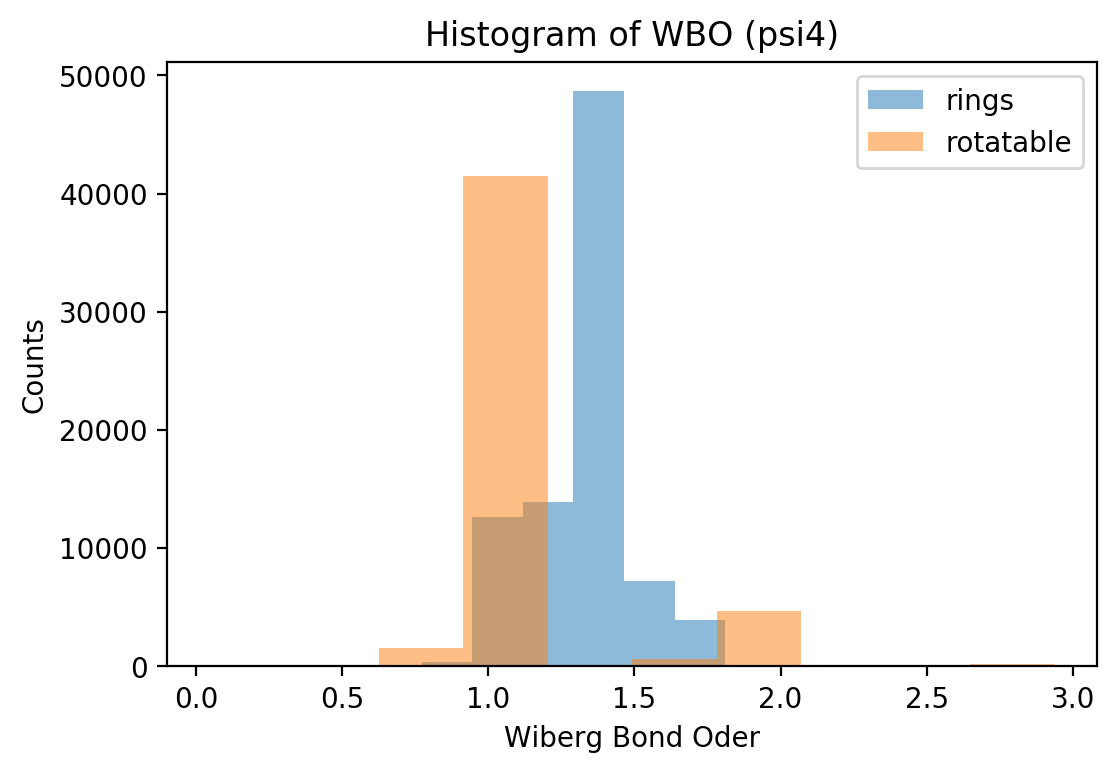

In [11]:
plt.figure(dpi=200)
plt.hist(all_bo_rings, alpha=0.5, label='rings');
plt.hist(all_bo_no_rings, alpha=0.5, label='rotatable');
plt.legend()
plt.title('Histogram of WBO (psi4)')
plt.xlabel('Wiberg Bond Oder')
plt.ylabel('Counts');
plt.savefig('Wiberg_psi4_hist.pdf')

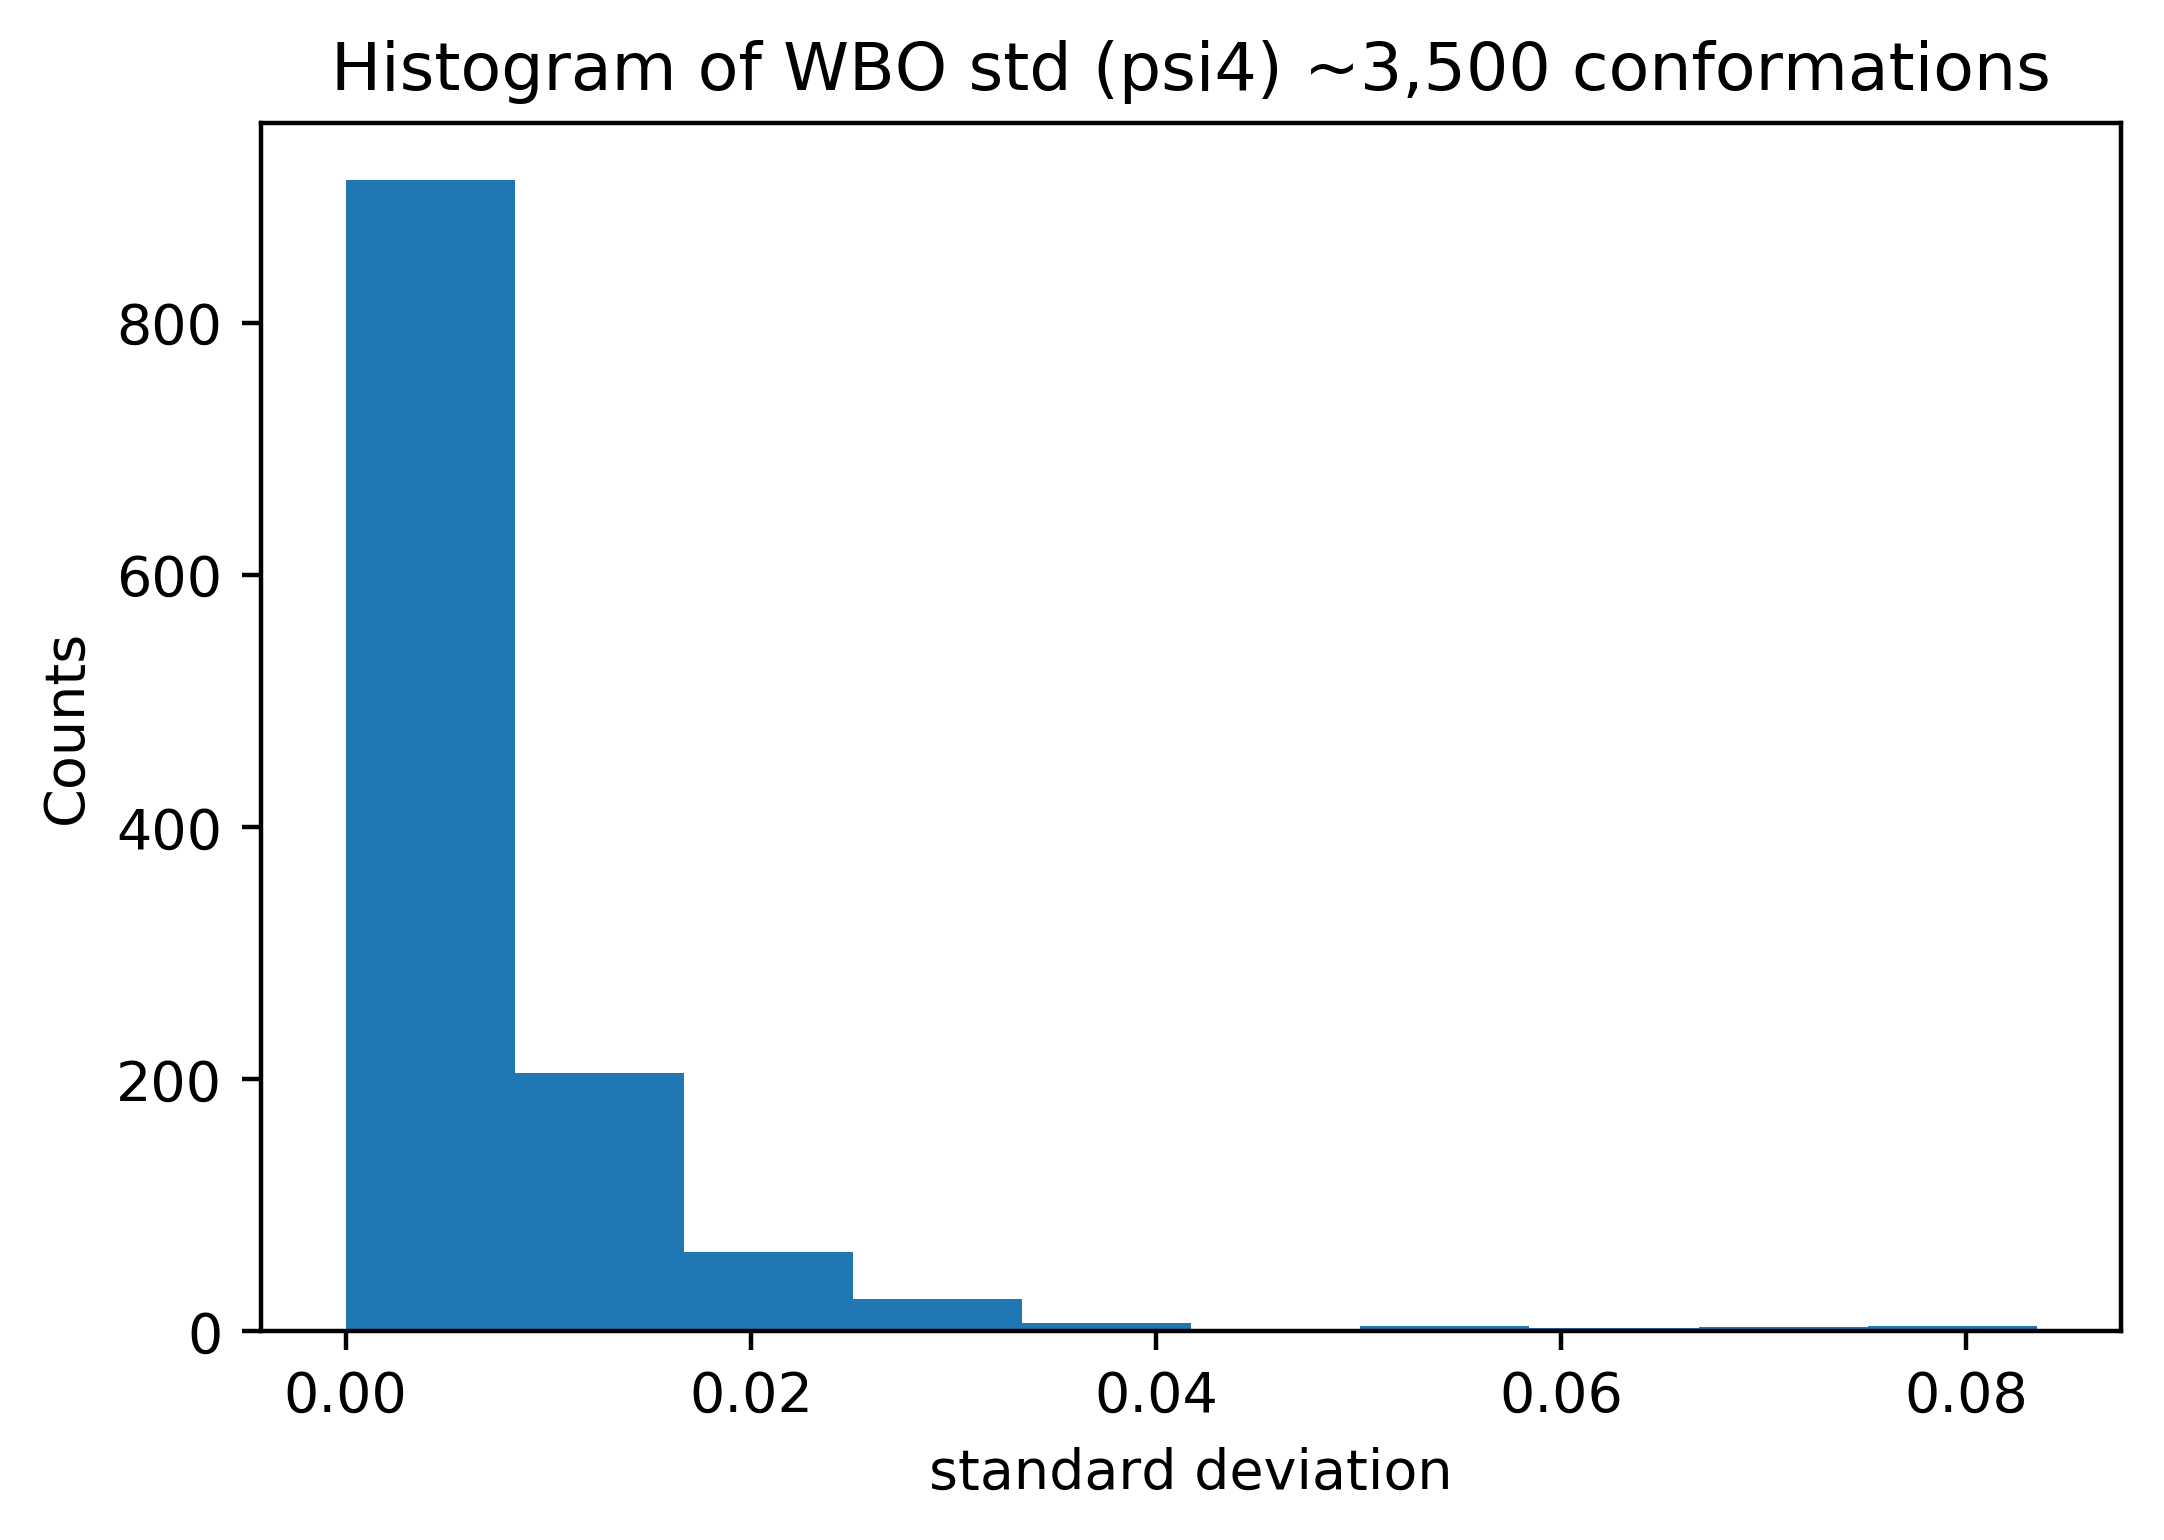

In [17]:
plt.figure(dpi=400)
plt.hist(all_std);
plt.title('Histogram of WBO std (psi4) ~3,500 conformations')
plt.xlabel('standard deviation')
plt.ylabel('Counts');
plt.savefig('wiberg_psi4_all_std.pdf')

In [22]:
# Look at variance of the non optimized molecules
directories = [x[0] for x in os.walk('../conjugation/bond_order_without_geomopt/')][1:]

In [25]:
output_no_opt = {}
for kinase_inhibitor in directories:
    ki_key = kinase_inhibitor.split('/')[-1]
    output_no_opt[ki_key] = []
    output_files = glob.glob('../conjugation/bond_order_without_geomopt/{}/*.output.json'.format(ki_key))
    for file in output_files:
        with open(file, 'r') as f:
            data = json.load(f)
        error = data['error']
        if error:
            print(error)
            continue
        data['bond_orders'] = chemi.bond_order_from_psi4_raw_output(data['raw_output'])
        data.pop('raw_output')
        output_no_opt[ki_key].append(data)

RuntimeError('\nFatal Error: Iterations did not converge.\nError occurred in file: /scratch/psilocaluser/conda-builds/psi4_1514132855674/work/psi4/src/psi4/libpsi4util/process.cc on line: 112\nThe most recent 5 function calls were:\n\npsi::die_if_not_converged()\npsi::scf::HF::finalize_E()\npsi::scf::HF::compute_energy()\n',)


In [15]:
confs = 0
for ki in output:
    confs += (len(output[ki]))

In [16]:
confs

3537